# Clustering of top 5 Chicago crimes types

This notebook documents the code that I used to implement K-means clustering algorithm on the 5 most representated crime types in Chicago city. The working dataset is the reputated Chicago crime dataset, which may be downloaded directly from [here](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2).

I wrote this notebook on Thursday, May 4, 2023 for the MSc in Artificial Intelligence and Big Data of the University of Málaga.

## Table of contents

- [Package imports](#Package-imports)
- [Initial Step. Create a SparkSession object](#Initial-Step.-Create-a-SparkSession-object)
- [Step 1. Load Chicago crimes dataset into a PySpark DataFrame](#Step-1.-Load-Chicago-crimes-dataset-into-a-PySpark-DataFrame)
- [Step 2. Filter the dataframe by the 5 crime types with the most number of incidences](#Step-2.-Filter-the-dataframe-by-the-5-crime-types-with-the-most-number-of-incidences)
- [Step 3. Perform K-means algorithm to cluster the features](#Step-3.-Perform-K-means-algorithm-to-cluster-the-features)
- [Step 4. Making predictions](#Step-4.-Making-predictions)
- [Step 5. Plotting the results](#Step-5.-Plotting-the-results)
- [Final Step. Stop SparkSession object](#Final-Step.-Stop-SparkSession-object)

## Packages imports

In [1]:
from pyspark import SparkConf  # the specific configuration for the Spark session
from pyspark.sql import SparkSession  # the entry point to programming PySpark with the DataFrame API
from pyspark.sql import functions  # kit of functions over DataFrame objects
from pyspark.ml.feature import VectorAssembler, StringIndexer  # to manipulate PySpark DataFrames objects
from pyspark.ml.clustering import KMeans  # K-means PySpark library of Machine Learning
import matplotlib.pyplot as plt  # to plot the clusters on a bidimensional chart
import numpy as np  # To work 12 times more efficiently with vectors

## Initial Step. Create a SparkSession object

In my case I name "ChicagoCrimesClustering" this application and use 6 cores, which are the number of cores of my computer.

In [2]:
spark_conf = SparkConf()\
    .setAppName("ChicagoCrimesClustering")\
    .set("spark.executor.memory", "4g") \
    .set("spark.driver.memory", "4g")

spark_session = SparkSession \
    .builder \
    .config(conf=spark_conf) \
    .master("local[6]") \
    .getOrCreate()

## Step 1. Load Chicago crimes dataset into a PySpark DataFrame

Now I read the dataset from a CSV file by specifying the path where the file is stored in disk. I am only interested in the columns "Primary Type", "Latitude" and "Longitude" so I select them and drop the rows with null values.

In [3]:
crime_dataframe = spark_session\
    .read\
    .csv('C:\\Users\\jlpuente\\Documents\\MBD\\M8_Spark_Hadoop\\python\\dataframe\\crimes_chicago.csv', header=True,
         inferSchema=True)\
    .select('Primary Type', 'Latitude', 'Longitude')\
    .na.drop()

In [4]:
crime_dataframe.printSchema()

root
 |-- Primary Type: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [5]:
crime_dataframe.describe().show()

+-------+-----------------+-------------------+-------------------+
|summary|     Primary Type|           Latitude|          Longitude|
+-------+-----------------+-------------------+-------------------+
|  count|          7678592|            7678592|            7678592|
|   mean|             null| 41.842180648616726| -87.67150011163386|
| stddev|             null|0.08880132455636114|0.06108499432693577|
|    min|            ARSON|       36.619446395|      -91.686565684|
|    max|WEAPONS VIOLATION|       42.022910333|      -87.524529378|
+-------+-----------------+-------------------+-------------------+



## Step 2. Filter the dataframe by the 5 crime types with the most number of incidences

I choose 5 as the number of clusters.

In [6]:
n_clusters = 5

I group by "Primary Type", then count the number of rows, then sort them descendingly (to leave at the top the higher ones) and finally select the first 5.

In [7]:
top_crimes_dataframe = crime_dataframe\
    .groupBy("Primary Type")\
    .count()\
    .orderBy(functions.desc("count"))\
    .limit(n_clusters)

In [8]:
top_crimes_dataframe.show()

+---------------+-------+
|   Primary Type|  count|
+---------------+-------+
|          THEFT|1617008|
|        BATTERY|1413485|
|CRIMINAL DAMAGE| 880345|
|      NARCOTICS| 734888|
|        ASSAULT| 503419|
+---------------+-------+



In [9]:
top_crime_types_dataframe = [row["Primary Type"] for row in top_crimes_dataframe.collect()]
filtered_crimes_dataframe = crime_dataframe\
    .filter(crime_dataframe["Primary Type"]
            .isin(top_crime_types_dataframe))

In [10]:
filtered_crimes_dataframe.show()

+---------------+------------+-------------+
|   Primary Type|    Latitude|    Longitude|
+---------------+------------+-------------+
|        BATTERY|41.815117282|-87.669999562|
|          THEFT|41.895080471|-87.765400451|
|      NARCOTICS|41.937405765|-87.716649687|
|        ASSAULT|41.881903443|-87.755121152|
|          THEFT|41.851988885|-87.689219118|
|          THEFT|41.763647552|-87.722344693|
|        BATTERY|41.975968415|-87.768014257|
|        BATTERY|41.809678314|-87.593638934|
|          THEFT|41.907127255|-87.678232016|
|        BATTERY|41.748097343|-87.662166183|
|CRIMINAL DAMAGE|41.893869916|-87.754341096|
|        BATTERY|41.949429769|-87.775435529|
|CRIMINAL DAMAGE|41.713031786|-87.536487809|
|CRIMINAL DAMAGE|41.972552295|-87.751076926|
|CRIMINAL DAMAGE|41.713031786|-87.536487809|
|CRIMINAL DAMAGE|41.713127829|-87.536486623|
|        ASSAULT|41.756330319|-87.552716204|
|        BATTERY|41.758420222|-87.565152335|
|          THEFT|41.752596188|-87.554055126|
|         

The number of rows is:

In [11]:
filtered_crimes_dataframe.count()

5149145

Among them there might be outliers, that is, coordinates that don't belong to Chicago city. After inspectioning Chicago on map, I know that it is inside a square whose diagonals goes from, roughly, (42.01, -87.95) to (41.64, -87.52). 

In [12]:
filtered_crimes_dataframe = filtered_crimes_dataframe\
                                    .filter((functions.col("Latitude") > 41.0) & (functions.col('Latitude') < 42.0))

In [13]:
filtered_crimes_dataframe.count()

5043499

In [14]:
filtered_crimes_dataframe = filtered_crimes_dataframe\
                                    .filter((functions.col("Longitude") > -87.95) & (functions.col('Longitude') < -87.52))

In [15]:
filtered_crimes_dataframe.count()

5043499

Now I convert the PySpark DataFrame into a new one in Machine Learning format, that is, it only has two columns: "features" and "label". I select the relevant columns from `filtered_crimes_dataframe`.

In [16]:
featured_columns = ["Latitude", "Longitude"]
label_column = "Primary Type"

I create a VectorAssembler to combine Latitude and Longitude columns into a vector of features.

In [17]:
assembler = VectorAssembler(inputCols=featured_columns, outputCol="features")

Apply the VectorAssembler to the `filtered_crimes_dataframe`.

In [18]:
assembled_crimes = assembler.transform(filtered_crimes_dataframe)

Create a StringIndexer object for the "Primary Type" column to convert it to a label

In [19]:
string_indexer = StringIndexer(inputCol=label_column, outputCol="label")

Apply the StringIndexer to the assembled_crimes dataframe.

In [20]:
indexer = string_indexer.fit(assembled_crimes)
dataframe = indexer \
    .transform(assembled_crimes) \
    .select('features', 'label')

Show the result.

In [21]:
dataframe.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[41.815117282,-87...|  1.0|
|[41.895080471,-87...|  0.0|
|[41.937405765,-87...|  3.0|
|[41.881903443,-87...|  4.0|
|[41.851988885,-87...|  0.0|
|[41.763647552,-87...|  0.0|
|[41.975968415,-87...|  1.0|
|[41.809678314,-87...|  1.0|
|[41.907127255,-87...|  0.0|
|[41.748097343,-87...|  1.0|
|[41.893869916,-87...|  2.0|
|[41.949429769,-87...|  1.0|
|[41.713031786,-87...|  2.0|
|[41.972552295,-87...|  2.0|
|[41.713031786,-87...|  2.0|
|[41.713127829,-87...|  2.0|
|[41.756330319,-87...|  4.0|
|[41.758420222,-87...|  1.0|
|[41.752596188,-87...|  0.0|
|[41.875367424,-87...|  0.0|
+--------------------+-----+
only showing top 20 rows



I write down the correspondence between the original "Primary Type" values and the new "label" values. I'll need it for the legend at the time to plot the results. Knowing that, by default, StringIndexer orders by label frequencies so the most frequent label gets index 0, the correct order to create the list is this: 

In [22]:
criminal_type_list = ['BATTERY', 'THEFT', 'NARCOTICS', 'ASSAULT', 'CRIMINAL DAMAGE']

## Step 3. Perform K-means algorithm to cluster the features

I create a K-means cluster and indicate the feature columns and the number of clusters `k`.

In [23]:
kmeans = KMeans(featuresCol='features', k=n_clusters)

Fit the model. It might take from few seconds to several minutes depending on computer resources provided to this assignment.

In [24]:
print('The model is starting to fit...')
model = kmeans.fit(dataframe)
print('The model has been fitted successfully.')

The model is starting to fit...
The model has been fitted successfully.


Compute centroids.

In [25]:
centroids = model.clusterCenters()

And count the number of points for each cluster.

In [26]:
points_by_cluster = model\
    .transform(dataframe)\
    .groupBy("prediction")\
    .count()\
    .orderBy("prediction")\
    .select("count")\
    .rdd\
    .flatMap(lambda x: x)\
    .collect()

In [27]:
points_by_cluster

[1011384, 1046504, 1079624, 615051, 1290936]

## Step 4. Making predictions

Now I predict the cluster labels for each data point by using the `transform()` method. It returns a single-column dataframe with "pediction" as header. I select this column and call `collect()` to make the driver get it as Python list for me.

In [28]:
print('Making predictions...')
predictions = model\
    .transform(dataframe)\
        .select('prediction')\
            .collect()
print('Predictions made.')

Making predictions...
Predictions made.


## Step 5. Plotting the results

In order to plot the results is necessary to split the "features" columns into "Latitudes" and "Longitudes". Converting the Spark dataframe into a Pandas one does exactly that.

In [29]:
print('Transforming PySpark DataFrame into a Pandas DataFrame...')
pandas_dataframe = dataframe.toPandas()
print('Transformation completed successfully.')

Transforming PySpark DataFrame into a Pandas DataFrame...
Transformation completed successfully.


Now I convert the Python list into a NumPy array to gain efficiency at the time to plot. I would say it's even mandatory due the fact there are 5 million of point to plot, which is a huge amount of points. The computing time of NumPy arrays is almost 12 times faster than standard Python lists.

In [30]:
predictions_np = np.array([row.prediction for row in predictions])
latitudes_np = np.array([[x[0]] for x in pandas_dataframe['features']])
longitudes_np = np.array([[x[1]] for x in pandas_dataframe['features']])

Let's display the boxplots for each array.

{'whiskers': [<matplotlib.lines.Line2D at 0x1e14799ac88>,
 'caps': [<matplotlib.lines.Line2D at 0x1e1ffbac4c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e1ff491208>],
 'medians': [<matplotlib.lines.Line2D at 0x1e1ffde1888>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e1fff22dc8>],
 'means': []}

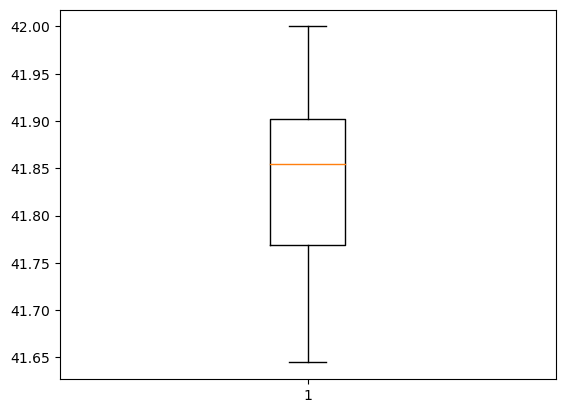

In [31]:
plt.boxplot(latitudes_np)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e2025d2708>,
 'caps': [<matplotlib.lines.Line2D at 0x1e202637388>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e2025bda48>],
 'medians': [<matplotlib.lines.Line2D at 0x1e20269a408>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e2026d3808>],
 'means': []}

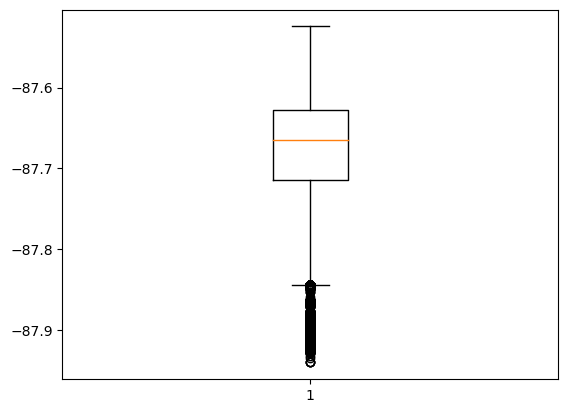

In [32]:
plt.boxplot(longitudes_np)

{'whiskers': [<matplotlib.lines.Line2D at 0x1e202cd1bc8>,
 'caps': [<matplotlib.lines.Line2D at 0x1e202d03f88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e202cc1748>],
 'medians': [<matplotlib.lines.Line2D at 0x1e202d34048>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e202d608c8>],
 'means': []}

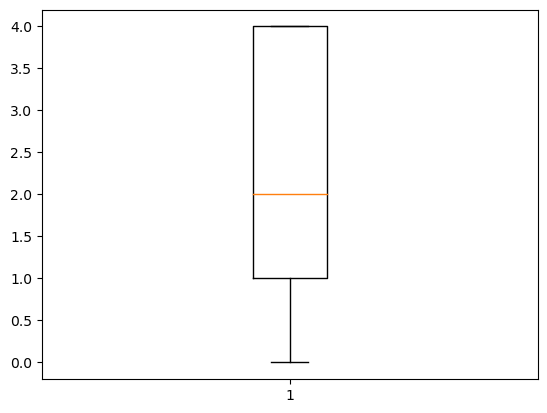

In [33]:
plt.boxplot(predictions_np)

Anything wrong with the boxplots.

And finally I plot the results.

The results are starting to plot...


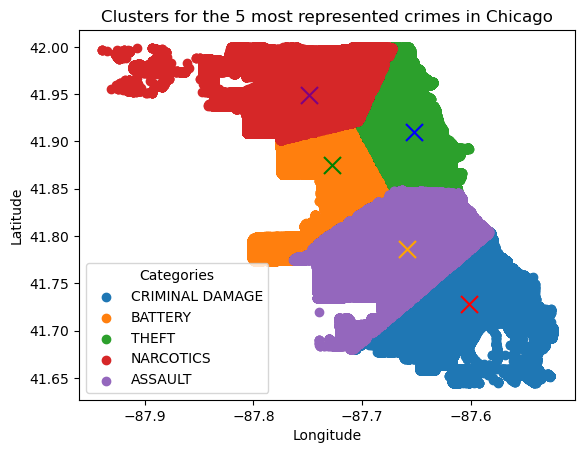

The plot has finished.


In [34]:
print('The results are starting to plot...')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.grid(False)

ax.set_title('Clusters for the 5 most represented crimes in Chicago')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

# Map numerical labels to strings
distinct_labels = np.unique(predictions_np)
distinct_labels_str = [criminal_type_list[i-1] for i in distinct_labels]

colors = ["red", "green", "blue", "purple", "orange"]
for i in range(len(distinct_labels)):
    ax.scatter(longitudes_np[predictions_np == distinct_labels[i]], 
                latitudes_np[predictions_np == distinct_labels[i]], 
                label=distinct_labels_str[i])
    ax.scatter(centroids[i][1], centroids[i][0], marker="x", color=colors[i], s=150)

ax.legend(loc='best', title='Categories')

plt.show()

print('The plot has finished.')

## Final Step. Stop SparkSession object

In order to perform a clean release of all allocated resources in memory it's a good practise to always stop the SparkSession object by ourselves.

In [35]:
spark_session.stop()

*(This is the end of the assignment.)*